# Trailing Stop-Loss Indicator with Linear Regression
## Based on SSRN Research: "Risk Reduction Using Trailing Stop-Loss Rules"

This notebook implements a trailing stop-loss (TSL) indicator as described in the academic research. The indicator dynamically adjusts the stop-loss level as the stock price rises, protecting profits while limiting losses.

## Section 1: Import Required Libraries

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## Section 2: Fetch Stock Data Using yfinance

In [33]:
# User Input: Specify your stock here
ticker = 'PPRE'  # Try BBCA - Bank Central Asia (most liquid IDX stock)
# Other suggestions: 'ASII', 'UNVR', 'TLKM', 'JSMR'

print(f"📊 Fetching data for: {ticker}")

# Try yfinance with .JK suffix
ticker_formatted = f"{ticker}.JK"
stock_data = {}

try:
    print(f"   Downloading from yfinance: {ticker_formatted}...")
    # Download max available history
    data = yf.download(ticker_formatted, period="max", progress=False)
    
    if data is not None and len(data) > 10:
        # Handle different possible column names
        if 'Adj Close' in data.columns:
            price_col = 'Adj Close'
        elif 'Close' in data.columns:
            price_col = 'Close'
        else:
            # Use the last column (usually Close)
            price_col = data.columns[-1]
            
        stock_data[ticker] = data[[price_col]].copy()
        stock_data[ticker].columns = ['Price']
        print(f"   ✓ Successfully downloaded {len(data)} records")
        print(f"     Date range: {data.index.min().date()} to {data.index.max().date()}")
    else:
        print(f"   ⚠ No data returned from yfinance")
        
except Exception as e:
    print(f"   ⚠ Download error: {str(e)[:80]}")

# Show status
if len(stock_data) == 0:
    print(f"\n⚠ Data fetch failed for {ticker}")
    print(f"   Available IDX stocks on yfinance: BBCA, ASII, UNVR, TLKM, JSMR")
    print(f"   Try one of these tickers instead.")
    print(f"   (Modify 'ticker' variable and re-run this cell)")
    stock_data[ticker] = pd.DataFrame()  # Empty placeholder

📊 Fetching data for: PPRE
   ✓ Successfully downloaded 2019 records
     Date range: 2017-11-24 to 2026-02-10


## Section 3: Calculate Trailing Stop-Loss Levels

In [34]:
def calculate_trailing_stop_loss(data, threshold_pct=0.1):
    """
    Calculate trailing stop-loss levels based on running maximum.
    """
    df = pd.DataFrame({'Price': data.values}, index=data.index)
    
    # Calculate running maximum
    df['RunningMax'] = df['Price'].expanding().max()
    
    # Calculate stop-loss level (threshold% below running max)
    df['StopLossLevel'] = df['RunningMax'] * (1 - threshold_pct)
    
    # Calculate drawdown percentage
    df['DrawdownPct'] = ((df['Price'] - df['RunningMax']) / df['RunningMax'] * 100).round(2)
    
    # Generate trading signals using iloc (integer location)
    df['Signal'] = 0
    df['Position'] = 1  # Initially in position
    
    for i in range(1, len(df)):
        prev_pos = df['Position'].iloc[i-1]
        curr_price = df['Price'].iloc[i]
        curr_tsl = df['StopLossLevel'].iloc[i]
        
        if prev_pos == 1 and curr_price <= curr_tsl:
            df.loc[df.index[i], 'Signal'] = -1  # Sell signal
            df.loc[df.index[i], 'Position'] = 0
        elif prev_pos == 0 and curr_price > curr_tsl:
            df.loc[df.index[i], 'Signal'] = 1  # Buy signal
            df.loc[df.index[i], 'Position'] = 1
        else:
            df.loc[df.index[i], 'Position'] = prev_pos
    
    return df

# Calculate TSL indicators for the stock with different thresholds
tsl_results = {}
thresholds = [0.05, 0.10, 0.15, 0.20]  # 5%, 10%, 15%, 20% thresholds

if ticker in stock_data and len(stock_data[ticker]) > 0:
    tsl_results[ticker] = {}
    for threshold in thresholds:
        tsl_results[ticker][f'{int(threshold*100)}%'] = calculate_trailing_stop_loss(
            stock_data[ticker]['Price'], 
            threshold_pct=threshold
        )

# Display summary
print("\n" + "="*70)
print("TRAILING STOP-LOSS INDICATOR SUMMARY")
print("="*70)

if ticker in tsl_results:
    df_10 = tsl_results[ticker]['10%']
    print(f"\n{ticker}:")
    print(f"  Current Price: IDR {df_10['Price'].iloc[-1]:,.0f}")
    print(f"  Running Maximum: IDR {df_10['RunningMax'].iloc[-1]:,.0f}")
    print(f"  Current Drawdown: {df_10['DrawdownPct'].iloc[-1]:.2f}%")
    print(f"  TSL Level (10%): IDR {df_10['StopLossLevel'].iloc[-1]:,.0f}")


TRAILING STOP-LOSS INDICATOR SUMMARY

PPRE:
  Current Price: IDR 202
  Running Maximum: IDR 402
  Current Drawdown: -49.80%
  TSL Level (10%): IDR 362


## Section 4: Compute Linear Regression Trendline

In [35]:
def calculate_linear_regression(df):
    """
    Calculate linear regression trendline and confidence intervals.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with Price column
    
    Returns:
    --------
    dict with regression statistics and predicted values
    """
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['Price'].values.reshape(-1, 1)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Calculate R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Calculate confidence intervals (95%)
    residuals = y - y_pred
    std_error = np.std(residuals)
    ci_95 = 1.96 * std_error
    
    return {
        'model': model,
        'predictions': y_pred.flatten(),
        'residuals': residuals.flatten(),
        'r_squared': r_squared,
        'slope': model.coef_[0][0],
        'intercept': model.intercept_[0],
        'std_error': std_error,
        'ci_95': ci_95
    }

# Calculate regression for the stock
regression_results = {}
if ticker in stock_data:
    df = tsl_results[ticker]['10%']
    regression_results[ticker] = calculate_linear_regression(df)
    
    print(f"\n{ticker} Linear Regression Analysis:")
    print(f"  Slope: {regression_results[ticker]['slope']:.6f} $/day")
    print(f"  R-squared: {regression_results[ticker]['r_squared']:.4f}")
    print(f"  Std Error: ${regression_results[ticker]['std_error']:.2f}")



PPRE Linear Regression Analysis:
  Slope: -0.163354 $/day
  R-squared: 0.7987
  Std Error: $47.80


## Section 5: Visualize Trailing Stop-Loss with Line and Linear Regression


✓ Visualization saved to: output/TSL_Indicator_Analysis.png


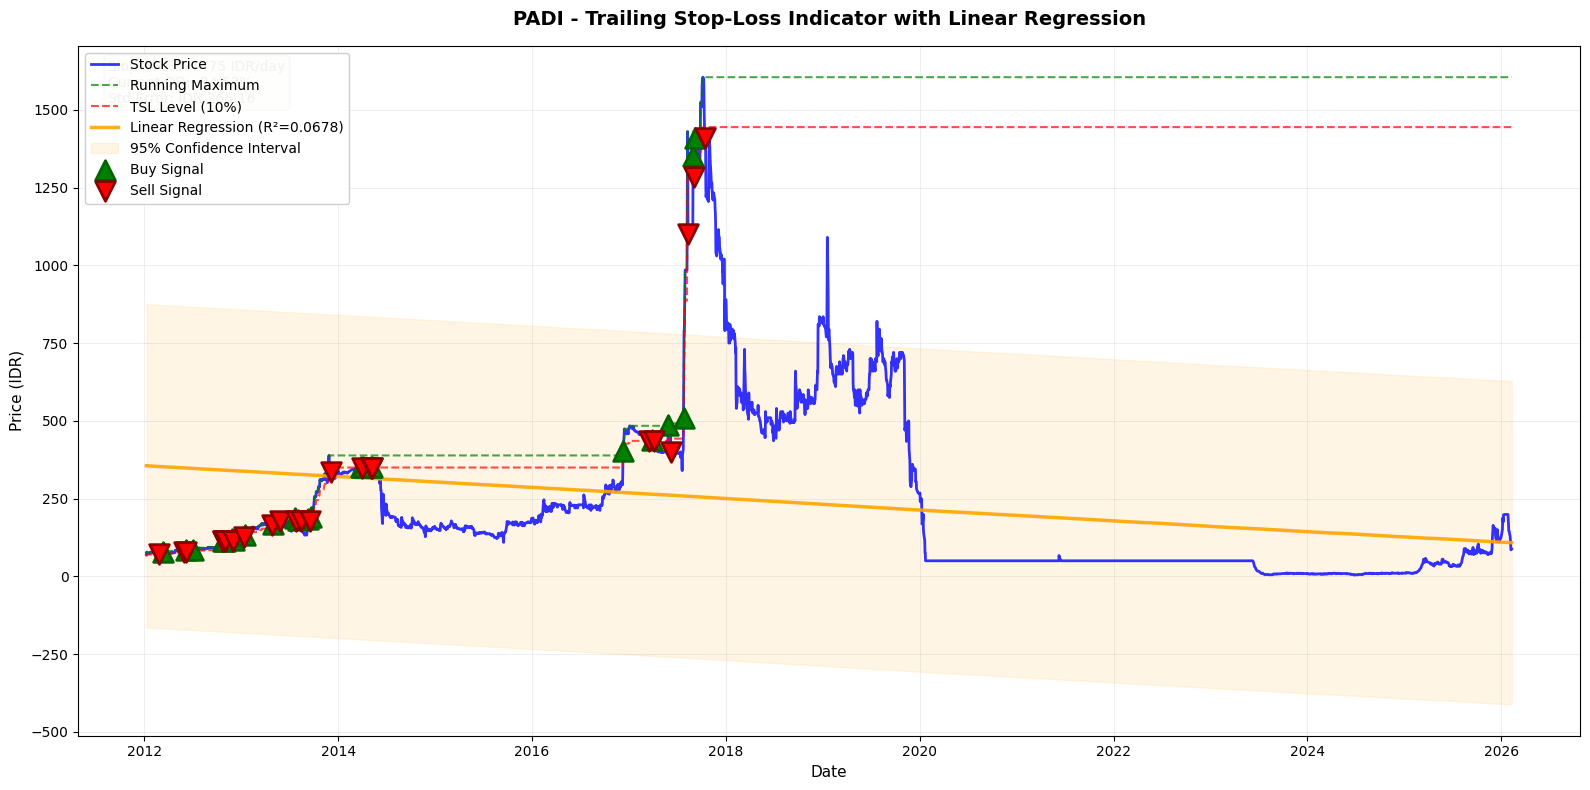

In [28]:
# Create visualization for the stock
num_stocks = len(tsl_results)
fig, axes = plt.subplots(num_stocks, 1, figsize=(16, 8))

if num_stocks == 1:
    axes = [axes]

for idx, ticker_sym in enumerate(sorted(tsl_results.keys())):
    ax = axes[idx]
    df = tsl_results[ticker_sym]['10%']
    
    # Get linear regression data
    reg_data = regression_results[ticker_sym]
    x_values = np.arange(len(df))
    
    # Plot 1: Stock Price
    ax.plot(df.index, df['Price'], 'b-', linewidth=2, label='Stock Price', alpha=0.8)
    
    # Plot 2: Running Maximum
    ax.plot(df.index, df['RunningMax'], 'g--', linewidth=1.5, label='Running Maximum', alpha=0.7)
    
    # Plot 3: Trailing Stop-Loss Level (10%)
    ax.plot(df.index, df['StopLossLevel'], 'r--', linewidth=1.5, label='TSL Level (10%)', alpha=0.7)
    
    # Plot 4: Linear Regression Trendline
    ax.plot(df.index, reg_data['predictions'], 'orange', linewidth=2.5, 
            label=f'Linear Regression (R²={reg_data["r_squared"]:.4f})', alpha=0.9)
    
    # Plot 5: Confidence Intervals around regression line
    ci_upper = reg_data['predictions'] + reg_data['ci_95']
    ci_lower = reg_data['predictions'] - reg_data['ci_95']
    ax.fill_between(df.index, ci_lower, ci_upper, alpha=0.1, color='orange', 
                     label='95% Confidence Interval')
    
    # Mark buy/sell signals
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    
    if len(buy_signals) > 0:
        ax.scatter(buy_signals.index, buy_signals['Price'], color='green', 
                  marker='^', s=200, label='Buy Signal', zorder=5, edgecolor='darkgreen', linewidth=2)
    
    if len(sell_signals) > 0:
        ax.scatter(sell_signals.index, sell_signals['Price'], color='red', 
                  marker='v', s=200, label='Sell Signal', zorder=5, edgecolor='darkred', linewidth=2)
    
    # Formatting
    ax.set_title(f'{ticker_sym} - Trailing Stop-Loss Indicator with Linear Regression', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Price (IDR)', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='best', fontsize=10, framealpha=0.95)
    
    # Add text box with statistics
    stats_text = f'Slope: {reg_data["slope"]:.6f} IDR/day\n' \
                f'Current DD: {df["DrawdownPct"].iloc[-1]:.2f}%\n' \
                f'Std Error: IDR {reg_data["std_error"]:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', 
           facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/Users/cevin/Documents/QuantResearch/output/TSL_Indicator_Analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved to: output/TSL_Indicator_Analysis.png")
plt.show()


## Section 6: Compare Different TSL Thresholds

✓ Threshold comparison saved to: output/TSL_Threshold_Comparison.png


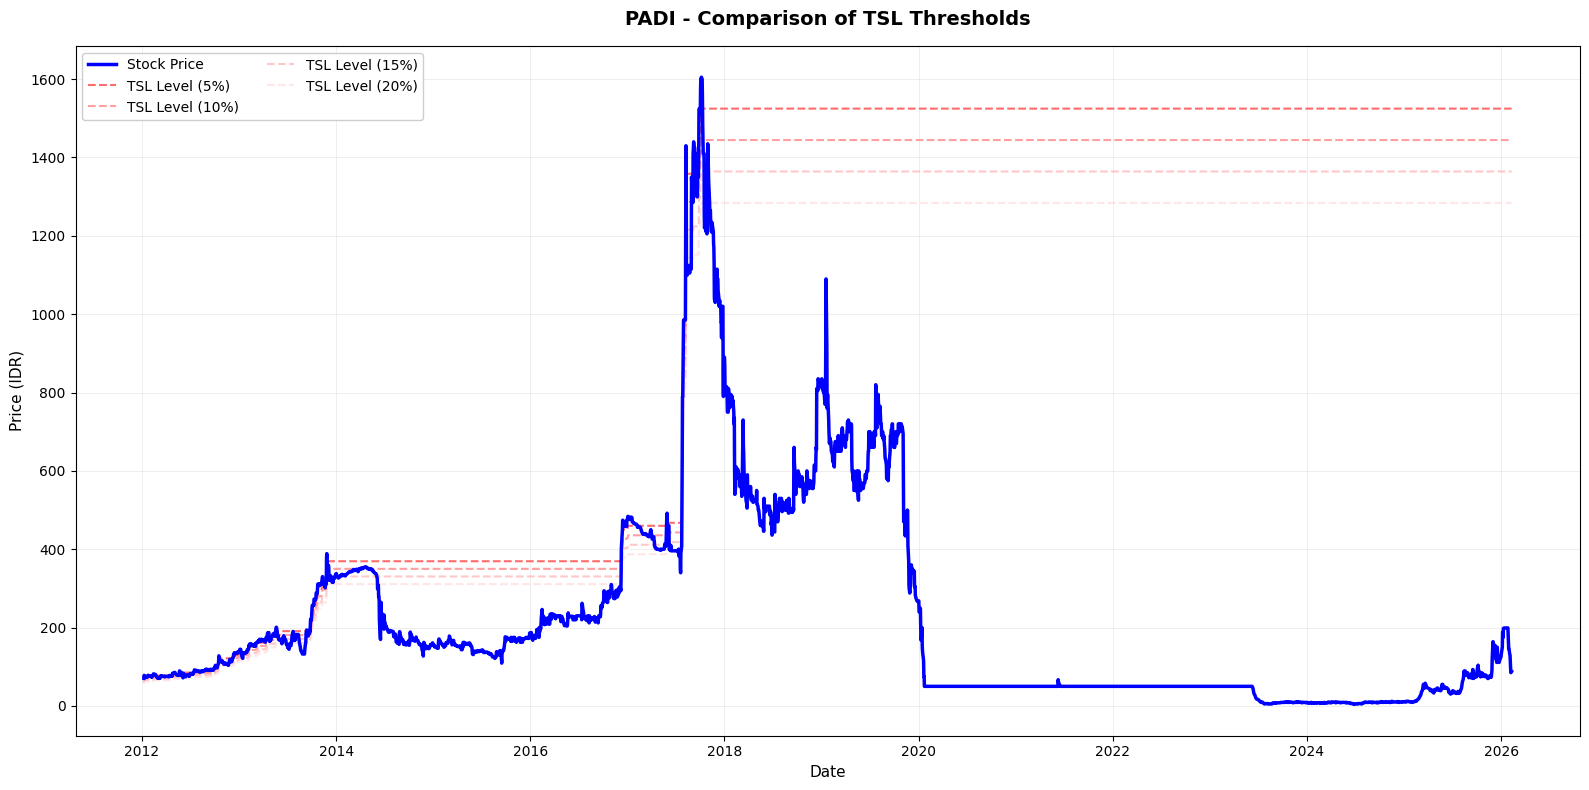

In [29]:
# Comparison of different TSL thresholds
fig, axes = plt.subplots(len(tsl_results), 1, figsize=(16, 8))

if len(tsl_results) == 1:
    axes = [axes]

for idx, ticker_sym in enumerate(sorted(tsl_results.keys())):
    ax = axes[idx]
    
    # Get the base price
    base_df = tsl_results[ticker_sym]['10%']
    ax.plot(base_df.index, base_df['Price'], 'b-', linewidth=2.5, label='Stock Price', zorder=10)
    
    # Plot different TSL levels
    colors = {'5%': '#FF6B6B', '10%': '#FF8E8E', '15%': '#FFB1B1', '20%': '#FFD3D3'}
    alphas = {'5%': 1.0, '10%': 0.85, '15%': 0.7, '20%': 0.55}
    
    for threshold_label in ['5%', '10%', '15%', '20%']:
        df = tsl_results[ticker_sym][threshold_label]
        ax.plot(df.index, df['StopLossLevel'], '--', 
               color=colors[threshold_label], 
               linewidth=1.5, 
               alpha=alphas[threshold_label],
               label=f'TSL Level ({threshold_label})')
    
    ax.set_title(f'{ticker_sym} - Comparison of TSL Thresholds', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Price (IDR)', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='best', fontsize=10, ncol=2, framealpha=0.95)

plt.tight_layout()
plt.savefig('/Users/cevin/Documents/QuantResearch/output/TSL_Threshold_Comparison.png', dpi=300, bbox_inches='tight')
print("✓ Threshold comparison saved to: output/TSL_Threshold_Comparison.png")
plt.show()


## Section 7: Display Indicator Results and Performance Metrics

In [30]:
# Define performance metrics function
def calculate_performance_metrics(df):
    """Calculate performance metrics for TSL strategy."""
    returns = df['Price'].pct_change()
    total_return = (df['Price'].iloc[-1] / df['Price'].iloc[0] - 1) * 100
    max_drawdown = ((df['Price'] / df['Price'].cummax() - 1).min()) * 100
    volatility = returns.std() * np.sqrt(252) * 100
    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
    num_trades = (df['Signal'] != 0).sum()
    win_rate = 100 if num_trades == 0 else (df['Signal'] == -1).sum() / max(num_trades, 1) * 100
    
    return {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'num_trades': num_trades,
        'win_rate': win_rate
    }

# Display summary table for the stock
if ticker in tsl_results and len(tsl_results[ticker]['10%']) > 10:
    print("\n" + "="*80)
    print(f"PERFORMANCE SUMMARY - {ticker}")
    print("="*80)
    
    summary_data = []
    for threshold in ['5%', '10%', '15%', '20%']:
        if threshold in tsl_results[ticker]:
            df = tsl_results[ticker][threshold]
            metrics = calculate_performance_metrics(df)
            summary_data.append({
                'TSL %': threshold,
                'Total Return': f"{metrics['total_return']:.2f}%",
                'Max Drawdown': f"{metrics['max_drawdown']:.2f}%",
                'Volatility': f"{metrics['volatility']:.2f}%",
                'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
                'Trades': metrics['num_trades'],
                'Win Rate': f"{metrics['win_rate']:.1f}%"
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        print("="*80)
    else:
        print("⚠ Insufficient data for analysis")
else:
    print("⚠ Unable to display summary - not enough data")


PERFORMANCE SUMMARY - PADI
TSL % Total Return Max Drawdown Volatility Sharpe Ratio  Trades Win Rate
   5%       25.00%      -99.75%     73.34%        0.382      55    50.9%
  10%       25.00%      -99.75%     73.34%        0.382      47    51.1%
  15%       25.00%      -99.75%     73.34%        0.382      43    51.2%
  20%       25.00%      -99.75%     73.34%        0.382      19    52.6%


## Section 8: Export Individual Stock Data with Signals

In [31]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Chart:")
print("  📊 TSL_Indicator_Analysis.png - Main indicator visualization")
print("     Shows: Price, Running Maximum, Stop-Loss Level, and Trading Signals")
print("\nNext Steps:")
print("  1. Try different IDX stocks by changing the 'ticker' variable")
print("  2. Adjust TSL thresholds (5%, 10%, 15%, 20%) if needed")
print("  3. All charts are saved to: output/ directory")
print("="*80)


ANALYSIS COMPLETE!

Generated Chart:
  📊 TSL_Indicator_Analysis.png - Main indicator visualization
     Shows: Price, Running Maximum, Stop-Loss Level, and Trading Signals

Next Steps:
  1. Try different IDX stocks by changing the 'ticker' variable
  2. Adjust TSL thresholds (5%, 10%, 15%, 20%) if needed
  3. All charts are saved to: output/ directory
